In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import paired_distances
from helpers.iaml01cw2_helpers import *

/afs/inf.ed.ac.uk/user/s18/s1864480/miniconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


In [2]:
%matplotlib inline

In [3]:
Xtrn, Ytrn, Xtst, Ytst = load_FashionMNIST("fashionMNIST/")

### Normalisation of data

In [4]:
Xtrn_orig = Xtrn.copy()
Xtst_orig = Xtst.copy()

In [5]:
Xtrn /= 255.0
Xtst /= 255.0

In [6]:
Xmean = np.mean(Xtrn, axis=0)
Xmean.shape

(784,)

In [7]:
Xtrn_nm = Xtrn - Xmean
Xtst_nm = Xtst - Xmean

### 1.1

In [8]:
# 1.1
np.round(Xtrn_nm[0, :4], 4), np.round(Xtrn_nm[-1, :4], 4)

(array([-0.    , -0.    , -0.0001, -0.0004]),
 array([-0.    , -0.    , -0.0001, -0.0004]))

The first four elements of the first and the last training are same. These are $[-3.13725490e-06, -2.26797386e-05, -1.17973856e-04, -4.07058824e-04]$

### 1.2

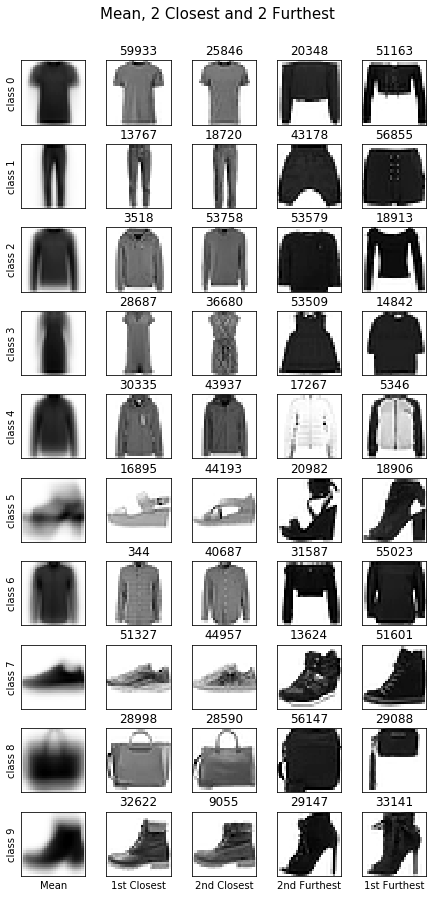

In [38]:
# 1.2
class_samples = {i: Xtrn[Ytrn == i] for i in range(10)}
class_mean_sample = {i: class_samples[i].mean(axis=0) for i in range(10)}
dist_to_class_mean_idx = {i: np.linalg.norm(class_samples[i] - class_mean_sample[i], axis=1).argsort() for i in range(10)}
sorted_by_class_mean = {i: class_samples[i][dist_to_class_mean_idx[i]] for i in range(10)}
samples_to_plot = {i: [class_mean_sample[i], *sorted_by_class_mean[i][:2], *sorted_by_class_mean[i][-2:]] for i in range(10)}
sample_indexes = {i: list(map(lambda x: (Xtrn == x).all(axis=1).nonzero()[0][0], samples_to_plot[i][1:])) for i in range(10)}

# Setting up the subplots
fig, ax = plt.subplots(nrows=10, ncols=5, sharex="col", sharey="row",
                figsize=(7.5, 15), subplot_kw={'xticks':[], 'yticks':[]},
                gridspec_kw=dict(hspace=0.3, wspace=0.1))

for i in range(10):
    for j in range(5):
        ax[i, 0].set_ylabel(f"class {i}")
        if j != 0:
            ax[i, j].title.set_text(f"{sample_indexes[i][j - 1]}")
        img = samples_to_plot[i][j].reshape((28, 28))
        ax[i, j].imshow(img, cmap="gray_r")

ax[-1, 0].set_xlabel("Mean")
ax[-1, 1].set_xlabel("1st Closest")
ax[-1, 2].set_xlabel("2nd Closest")
ax[-1, 3].set_xlabel("2nd Furthest")
ax[-1, 4].set_xlabel("1st Furthest")
fig.suptitle("Mean, 2 Closest and 2 Furthest", fontsize=15, y=0.93)
plt.savefig("results/1_2.png")
plt.show()

### 1.3

In [20]:
# 1.3
pca = PCA(n_components=784).fit(Xtrn_nm)

In [21]:
np.round(pca.explained_variance_[:5], 4)

array([19.8098, 12.1122,  4.1062,  3.3818,  2.6248])

The explained variances of the first five components are $[19.8098, 12.1122,  4.1062,  3.3818,  2.6248]$

### 1.4

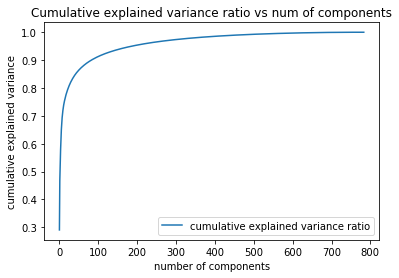

In [22]:
# 1.4
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="cumulative explained variance ratio")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Cumulative explained variance ratio vs num of components")
plt.legend()
plt.savefig("results/1_4.png")
plt.show()

This curve shows how much of the total, 784-dimensional variance is contained within the first $N$ components. Here we can see that in the dataset the first 100 components contain approximately 90% of the variance, while we need around 500 components to describe close to 100% of the variance.

### 1.5

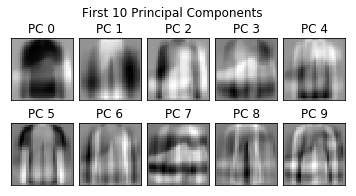

In [27]:
# 1.5
pca_comp_to_plot = pca.components_[:10]
fig, ax = plt.subplots(nrows=2, ncols=5, sharex="col", sharey="row",
                figsize=(6, 3), subplot_kw={'xticks':[], 'yticks':[]},
                gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(2):
    for j in range(5):
        image = pca_comp_to_plot[5*i + j].reshape((28,28))
        ax[i, j].title.set_text(f"PC {5*i + j}")
        ax[i, j].imshow(image, cmap='gray_r')
fig.suptitle("First 10 Principal Components", y=0.99)
plt.savefig("results/1_5.png")
plt.show()

### 1.6

In [28]:
# 1.6
K = [5,20,50,200]
pca_dict = {k: PCA(k).fit(Xtrn_nm) for k in K}
class_rmses = {}
for i in range(10):
    mask = Ytrn == i
    class_vecs = Xtrn_nm[mask]
    first_sample = class_vecs[0].reshape(1, 784)
    rmses = []
    for k in K:
        first_sample_pca = pca_dict[k].transform(first_sample)
        first_sample_new = pca_dict[k].inverse_transform(first_sample_pca)
        rmse = mean_squared_error(first_sample, first_sample_new) ** 0.5
        rmses.append(rmse)
    class_rmses[i] = rmses

In [29]:
import pprint
pprint.pprint(class_rmses)

{0: [0.2561486641626059,
     0.15001804933072116,
     0.1274873622218298,
     0.05972491137102975],
 1: [0.19802439572926014,
     0.14048353241180053,
     0.09553973967216,
     0.03536089248974406],
 2: [0.19870015530301186,
     0.1455691051172875,
     0.1234858253652776,
     0.08240985714602243],
 3: [0.14565797909429753,
     0.10712051996200204,
     0.08363938884165596,
     0.0567741206697194],
 4: [0.11820870328504021,
     0.10266806708833909,
     0.08778809070935327,
     0.04692936021980893],
 5: [0.1811297586373514,
     0.15883186551187353,
     0.1428450873181701,
     0.09018338142061821],
 6: [0.129479278011839,
     0.09594213926104701,
     0.07243355429920914,
     0.04551883323309609],
 7: [0.16562538200808263,
     0.1277692211890249,
     0.10657957390953685,
     0.06274076808766418],
 8: [0.2233965873861244,
     0.14507129743474687,
     0.12445992157891825,
     0.09231054394183129],
 9: [0.1835104208312975,
     0.15114509807759688,
     0.12199289237

### 1.7

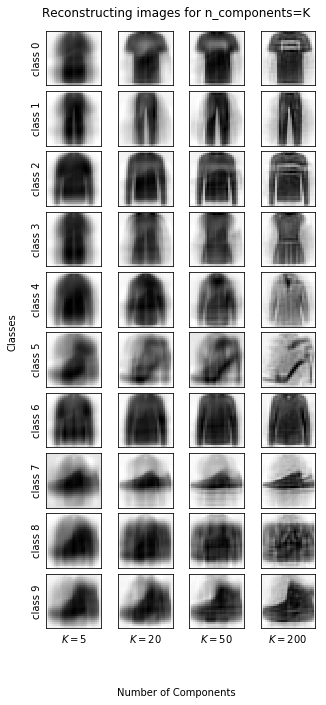

In [31]:
# 1.7
fig, ax = plt.subplots(10, 4, figsize=(5, 11),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
K = [5,20,50,200]
pca_dict = {k: PCA(k).fit(Xtrn_nm) for k in K}
for i in range(10):
    mask = Ytrn == i
    class_vecs = Xtrn[mask]
    first_sample = class_vecs[0].reshape(1, 784)
    rmses = []
    ax[i, 0].set_ylabel(f"class {i}")
    for j, k in enumerate(K):
        first_sample_pca = pca_dict[k].transform(first_sample)
        first_sample_new = pca_dict[k].inverse_transform(first_sample_pca)
        image = (Xmean + first_sample_new).reshape(28, 28)
        ax[i, j].imshow(image, cmap="gray_r")
ax[-1, 0].set_xlabel("$K=5$")
ax[-1, 1].set_xlabel("$K=20$")
ax[-1, 2].set_xlabel("$K=50$")
ax[-1, 3].set_xlabel("$K=200$")

fig.text(0.5, 0.04, 'Number of Components', ha='center')
fig.text(0.03, 0.5, 'Classes', va='center', rotation='vertical')
fig.suptitle("Reconstructing images for n_components=K", y=0.91)
plt.savefig("results/1_7.png")
plt.show()

### 1.8

In [32]:
# 1.8
pca_2d = PCA(2)  # project from 784 to 2 dimensions
projected = pca_2d.fit_transform(Xtrn_nm)

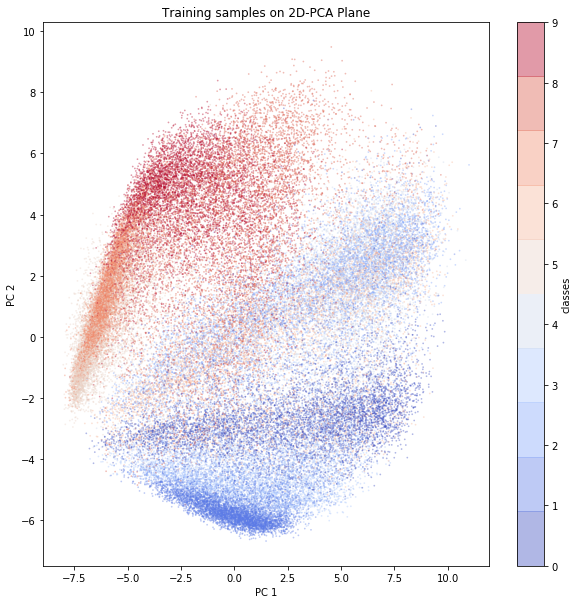

In [36]:
plt.figure(figsize=(10, 10))
plt.scatter(projected[:, 0], projected[:, 1],
            s=3, c=Ytrn, edgecolor='none',
            alpha=0.4, cmap=plt.cm.get_cmap('coolwarm', 10))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
cbar = plt.colorbar()
cbar.ax.set_ylabel('classes')
plt.title("Training samples on 2D-PCA Plane")
plt.savefig("results/1_8.png")
plt.show()